In [1]:
using ITensors, ITensorMPS, Plots, LaTeXStrings
using ProgressMeter,Graphs
push!(LOAD_PATH, ".")
using BP

## Ising TN
However, we will not use the graph object except for constructing the TN.

In [2]:
function get_ising_tn(g,N,β;h=0)
    # ising TN with no open indices 
    # g: Graph object
    # N: number of nodes in the graph 
    # β: inverse temp (K_b = 1)
    # J = 1; optional field h
    indmat = [Index(2, "i$(i)j$(j)") for i in 1:N, j in 1:N]
    T = []
    for index = 1:N
        indices = []
        nbrs = neighbors(g, index)
        for nbr in nbrs
            push!(indices,indmat[min(index,nbr),max(index,nbr)]) ## index --> nbr
        end 
        Ti = ITensor(indices)
        spin = i -> 3 - 2*i ## 1 -> 1, 2 -> -1
        for i1 in 1:2, i2 in 1:2, i3 in 1:2, i4 in 1:2
            s = spin(i1)*spin(i2) + spin(i2)*spin(i3) + spin(i3)*spin(i4) + spin(i4)*spin(i1) 
            s += h*(spin(i1) + spin(i2) + spin(i3) + spin(i4))/2 # divvy by two to avoid double counting
            Ti[i1,i2,i3,i4] = exp(-β * s)
        end 
        # Ti = Ti / norm(Ti) NOT normalizing,
        push!(T,Ti)    
    end 
    return T
end

function periodic_square_lattice(L::Int)
    g = Graph(L^2)

    # Correct row-major indexing
    idx(i, j) = (i - 1) * L + j
    
    for i in 1:L
        for j in 1:L
            current = idx(i, j)
            right = j < L ? idx(i, j + 1) : idx(i, 1)  # Wrap rightmost to first column
            down = i < L ? idx(i + 1, j) : idx(1, j)    # Wrap bottom to top row
            add_edge!(g, current, right)
            add_edge!(g, current, down)
        end
    end
    return g
end

## analytical free energy, Onsager's solution 

# Define free energy per spin for 2D Ising model with no magnetic field
function free_energy(β::Float64)
    sinh2β = sinh(2 * β)
    cosh2β = cosh(2 * β)
    k = (sinh2β / (cosh2β^2))/2

    integrand(kx, ky) = log(1 - 2 * k * (cos(kx) + cos(ky))) 
    
    integral, _ = hcubature(
        x -> integrand(x[1], x[2]),
        [0.0, 0.0], [π, π],
        rtol=1e-9  # Adjust tolerance for precision
    )
    f = log(2*cosh2β) + integral / (2 * π^2)
    return -f #/β  # multiply by T because f = -T * ( ... )
end



free_energy (generic function with 1 method)

## Sanity check: 2D Ising Phase Transition

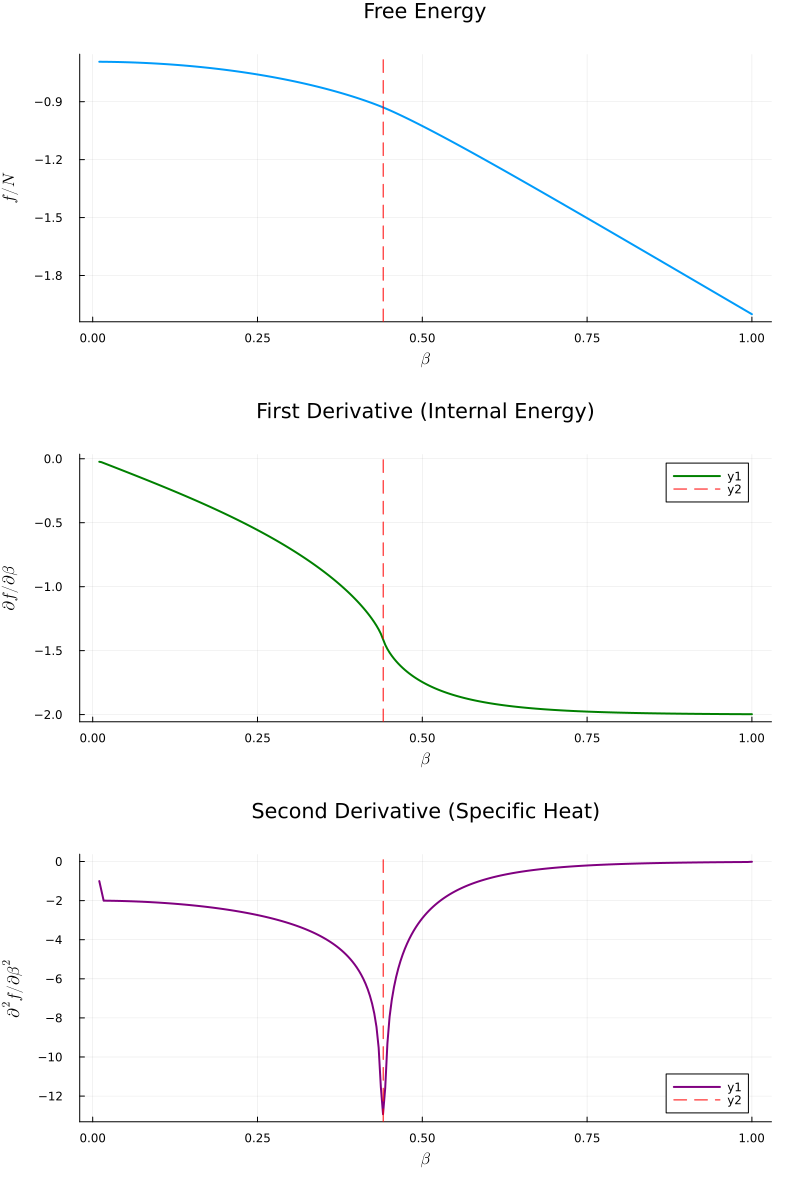

In [ ]:
 

function compute_derivatives(βs, fs)
    Δβ = βs[2] - βs[1]  # Assumes uniform spacing
    
    # First derivative using central differences
    dfdβ = [(fs[i+1] - fs[i-1])/(2Δβ) for i in 2:length(fs)-1]
    dfdβ = vcat([(fs[2] - fs[1])/Δβ], dfdβ, [(fs[end] - fs[end-1])/Δβ])
    
    # Second derivative using central differences
    d2fdβ2 = [(dfdβ[i+1] - dfdβ[i-1])/(2Δβ) for i in 2:length(dfdβ)-1]
    d2fdβ2 = vcat([(dfdβ[2] - dfdβ[1])/Δβ], d2fdβ2, [(dfdβ[end] - dfdβ[end-1])/Δβ])
    
    return dfdβ, d2fdβ2
end
β_c=log(1+sqrt(2))/2
βs = range(.01, 1., length=300)
fs = [free_energy(β) for β in βs]
dfdβ, d2fdβ2 = compute_derivatives(βs, fs)
p1 = plot(βs, fs, xlabel=L"\beta", ylabel=L"f/N", 
            title="Free Energy", linewidth=2, legend=false)
            
vline!([β_c], linestyle=:dash, color=:red)

p2 = plot(βs, dfdβ, xlabel=L"\beta", ylabel=L"\partial f/\partial \beta", 
            title="First Derivative (Internal Energy)", color=:green, linewidth=2)
vline!([β_c], linestyle=:dash, color=:red)

p3 = plot(βs, d2fdβ2, xlabel=L"\beta", ylabel=L"\partial^2 f/\partial \beta^2", 
            title="Second Derivative (Specific Heat)", color=:purple, linewidth=2)
vline!([β_c], linestyle=:dash, color=:red)

plot(p1, p2, p3, layout=(3,1), size=(800,1200), margin=5Plots.mm)


## check if runs 

In [7]:
L = 6
g = periodic_square_lattice(L)
N = L^2 

β = .1
tensors = get_ising_tn(g,N,β;h=0.0);
adj_mat, edges, links = BP.get_adj_mat(tensors)
messages = BP.get_messages(tensors,edges,links)
messages = BP.message_passing(tensors,messages,edges,links,adj_mat;α=0.75,diagnose=false);


## plots

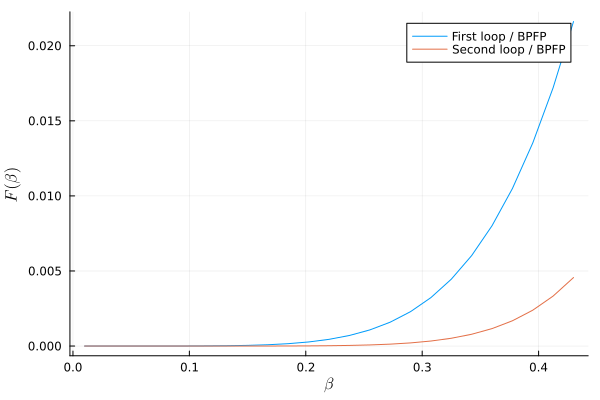

In [8]:
loop1_free_energy = [] 
loop2_free_energy = [] 
loop3_free_energy = []
βs = range(.01, .43 , length=25)
loop1 = [(1,2),(2,8),(7,8),(1,7)]
loop2 = [(1,2),(2,3),(3,9),(8,9),(7,8),(1,7)]
for β in βs
    tensors = get_ising_tn(g,N,β;h=0.0)
    adj_mat, edges, links = BP.get_adj_mat(tensors)
    messages = BP.get_messages(tensors,edges,links)
    messages = BP.message_passing(tensors,messages,edges,links,adj_mat)
    Z_mf = BP.mean_free_partition_fn(Set(1:N),tensors,messages,edges,links,adj_mat)
    Z_1loop =  BP.loop_contribution(loop1,messages,tensors,edges,links,adj_mat)
    Z_2loop =  BP.loop_contribution(loop2,messages,tensors,edges,links,adj_mat)
    push!(loop1_free_energy,Z_1loop./Z_mf )
    push!(loop2_free_energy,Z_2loop./Z_mf )
end
plot(βs, loop1_free_energy, label="First loop / BPFP", xlabel=L"β", ylabel=L"F(β)", legend=:topright)
plot!(βs, loop2_free_energy, label="Second loop / BPFP", xlabel=L"β", ylabel=L"F(β)", legend=:topright)


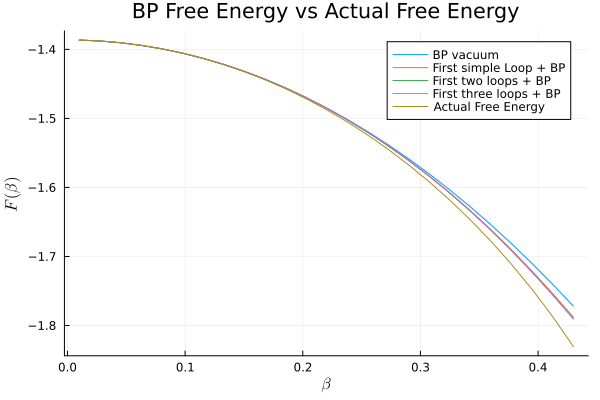

In [9]:
using HCubature

mf_free_energy = [] 
loop1_free_energy = [] 
loop2_free_energy = [] 
loop3_free_energy = []
actual_free_energy = []
loop1 = [(1,2),(2,8),(7,8),(1,7)]
loop2 = [(1,2),(2,3),(3,9),(8,9),(7,8),(1,7)]
loop3 = [(1,2),(2,3),(3,9),(8,9),(7,8),(1,7),(2,8)]
βs = range(.01, .43 , length=25)
for β in βs
    tensors = get_ising_tn(g,N,β;h=0.0)
    adj_mat, edges, links = BP.get_adj_mat(tensors)
    messages = BP.get_messages(tensors,edges,links)
    messages = BP.message_passing(tensors,messages,edges,links,adj_mat)
    Z_mf = BP.mean_free_partition_fn(Set(1:N),tensors,messages,edges,links,adj_mat)
    Z_1loop =  N * BP.loop_contribution(loop1,messages,tensors,edges,links,adj_mat)
    Z_2loop =  N * BP.loop_contribution(loop2,messages,tensors,edges,links,adj_mat)
    Z_3loop =  N * BP.loop_contribution(loop3,messages,tensors,edges,links,adj_mat)
    push!(mf_free_energy,- log(Z_mf)/N)
    push!(loop1_free_energy,- log(Z_mf + Z_1loop)/N )
    push!(loop2_free_energy,- log(Z_mf + Z_1loop + Z_2loop)/N )
    push!(loop3_free_energy,- log(Z_mf + Z_1loop + Z_2loop + Z_3loop)/N)
    push!(actual_free_energy,free_energy(β) * 2)
end
plot(βs, mf_free_energy, label="BP vacuum", xlabel=L"β", ylabel=L"F(β)", title="BP Free Energy vs Actual Free Energy", legend=:topright)
plot!(βs, loop1_free_energy, label="First simple Loop + BP", xlabel=L"β", ylabel=L"F(β)", legend=:topright)
plot!(βs, loop2_free_energy, label="First two loops + BP", xlabel=L"β", ylabel=L"F(β)", legend=:topright)
plot!(βs, loop3_free_energy, label="First three loops + BP", xlabel=L"β", ylabel=L"F(β)", legend=:topright)
plot!(βs, actual_free_energy, label="Actual Free Energy", xlabel=L"β", ylabel=L"F(β)", legend=:topright)
# β_c=log(1+sqrt(2))/2
# vline!([β_c], linestyle=:dash, color=:red,label=L"\beta_c")

